Iteration 1, Eigenvalue: -783.858461, Error: 1.400071e+01
Iteration 2, Eigenvalue: -783.870045, Error: 5.278376e-01
Iteration 3, Eigenvalue: -783.869096, Error: 1.979998e+01
Iteration 4, Eigenvalue: -783.869147, Error: 1.941759e-03
Iteration 5, Eigenvalue: -783.869145, Error: 4.948417e-04
Iteration 6, Eigenvalue: -783.869145, Error: 1.980000e+01
Iteration 7, Eigenvalue: -783.869145, Error: 6.750423e-04
Iteration 8, Eigenvalue: -783.869145, Error: 1.980000e+01
Iteration 9, Eigenvalue: -783.869145, Error: 9.155512e-04
Iteration 10, Eigenvalue: -783.869145, Error: 1.980000e+01
Iteration 11, Eigenvalue: -783.869145, Error: 6.640346e-04
Iteration 12, Eigenvalue: -783.869145, Error: 1.980000e+01
Iteration 13, Eigenvalue: -783.869145, Error: 7.187548e-04
Iteration 14, Eigenvalue: -783.869145, Error: 1.980000e+01
Iteration 15, Eigenvalue: -783.869145, Error: 8.879471e-04
Iteration 16, Eigenvalue: -783.869145, Error: 9.592921e-04
Iteration 17, Eigenvalue: -783.869145, Error: 1.980000e+01
Iterat

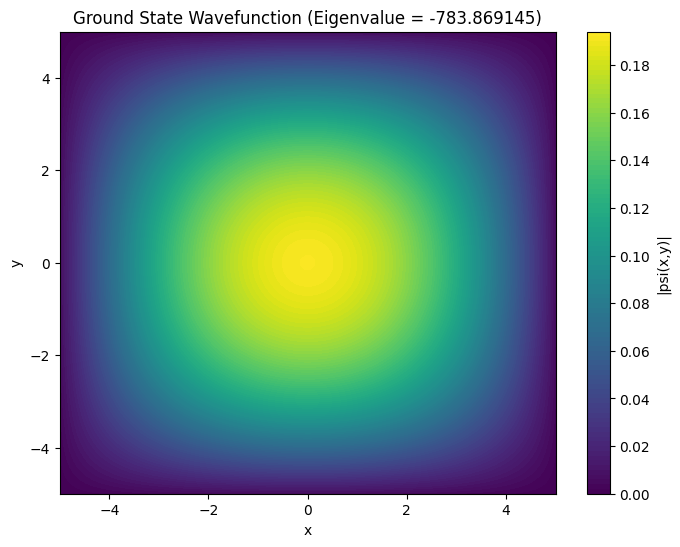

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

# Parameters
Lx = 10.0  # Length of the domain in x
Ly = 10.0  # Length of the domain in y
Nx = 100   # Number of grid points in x
Ny = 100   # Number of grid points in y
g = 1.0    # Nonlinear interaction strength
tol = 1e-6 # Convergence tolerance

# Discretization
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
x = np.linspace(-Lx / 2, Lx / 2, Nx)
y = np.linspace(-Ly / 2, Ly / 2, Ny)
X, Y = np.meshgrid(x, y)

# Create the Laplacian operator using finite differences
def create_laplacian(Nx, Ny, dx, dy):
    # 1D second derivative for x and y directions
    Dxx = diags([-2, 1, 1], [0, -1, 1], shape=(Nx, Nx)) / dx**2
    Dyy = diags([-2, 1, 1], [0, -1, 1], shape=(Ny, Ny)) / dy**2
    # 2D Laplacian (Kronecker sum)
    Laplacian = np.kron(Dxx.toarray(), np.eye(Ny)) + np.kron(np.eye(Nx), Dyy.toarray())
    return Laplacian

# Create the Laplacian matrix
L = create_laplacian(Nx, Ny, dx, dy)

# Initial guess for psi (normalized Gaussian)
psi0 = np.exp(-(X**2 + Y**2))

# Normalize psi
psi0 /= np.sqrt(np.sum(psi0**2) * dx * dy)

# Reshape psi0 into a vector for easier manipulation
psi0 = psi0.flatten()

# Nonlinear iteration
def solve_gpe(psi0, L, g, Nx, Ny, dx, dy, tol=1e-6, max_iter=100):
    psi = psi0.copy()
    for i in range(max_iter):
        # Nonlinear term: g * |psi|^2
        nonlinear_term = g * np.abs(psi)**2

        # Hamiltonian: -∇² + g|ψ|²
        H = L + diags(nonlinear_term).toarray()

        # Solve for the lowest eigenvalue and corresponding eigenfunction
        eigvals, eigvecs = eigsh(H, k=1, which='SA', tol=tol)
        lambda_ = eigvals[0]
        psi_new = eigvecs[:, 0]

        # Normalize the new psi
        psi_new /= np.sqrt(np.sum(psi_new**2) * dx * dy)

        # Convergence check
        error = np.linalg.norm(psi_new - psi)
        print(f"Iteration {i+1}, Eigenvalue: {lambda_:.6f}, Error: {error:.6e}")

        if error < tol:
            print(f"Converged after {i+1} iterations.")
            break

        psi = psi_new

    return psi, lambda_

# Solve the GPE
psi_sol, lambda_sol = solve_gpe(psi0, L, g, Nx, Ny, dx, dy, tol)

# Reshape the solution to 2D
psi_sol_2D = psi_sol.reshape((Ny, Nx))

# Plot the resulting wavefunction
plt.figure(figsize=(8,6))
plt.contourf(X, Y, np.abs(psi_sol_2D), 100, cmap='viridis')
plt.colorbar(label='|psi(x,y)|')
plt.title(f'Ground State Wavefunction (Eigenvalue = {lambda_sol:.6f})')
plt.xlabel('x')
plt.ylabel('y')
plt.show()